# Исследование эффективности "двойственного" алгоритма 
### Решение "двойственной" задачи к задаче минимизации максимального штрафа

## Код алгоритма

In [55]:
import random
import pickle
import threading
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.optimize import curve_fit
from multiprocessing.pool import ThreadPool

Класс для одного требования. **Расписание**, таким образом, -- список объектов класса `Task`

*Прим. к генерации значений* (см docstring класса `Task`):<br>
Как следует из теорем *1.1* и *1.4*, даже несмотря на наличие примеров с d<sub>j</sub> < r<sub>j</sub>, существует эквивалентный сгенерированному пример с d<sub>j</sub> > r<sub>j</sub>. Тем не менее, для выполнения условия достаточно задать параметр `NNTS=True` (NNTS - non-negative time slack)

In [56]:
class Task:
    """
    A class for a single task.
    
    Init parameters:
        rMin, rMax -- recievement time limits
        pMin, pMax -- process time limits
        dMin, dMax -- due date limits
        
    For each task the recievement time, process time and due date
    are calculated randomly (uniform distribution) between given limits.
    Default limit values are in the code below.
    
    Additional parameters:
        phi -- the loss function for this particular task.
        By default returns its argument without changing it
    """
    r = 0
    p = 0
    d = 0
    phi = None
            
    def gen_r(self, rMin, rMax):
        self.r = int(random.uniform(rMin, rMax))
        
    def gen_p(self, pMin, pMax):
        self.p = int(random.uniform(pMin, pMax))
        
    def gen_d(self, dMin, dMax):
        self.d = int(random.uniform(dMin, dMax))
    
    def __init__(self,
                 NNTS=False,
                 rMin = 1,
                 rMax = 100,
                 pMin = 1,
                 pMax = 100,
                 dMin = 1,
                 dMax = 200,
                 dDelta = 100,
                 **kwargs):
        self.gen_r(rMin, rMax)
        self.gen_p(pMin, pMax)
        if NNTS:
            dMin = self.r + self.p
            dMax = dMin + dDelta
        self.gen_d(dMin, dMax)
        self.phi = kwargs.get('phi', lambda x: x)
        
    def show(self):
        print("r =", self.r, "| p =", self.p, "| d =", self.d)
        
    @staticmethod
    def show_all(tasks):
        """
        Show r, p, d for each task from the 'tasks' list 
        """
        print(" r", "p", "d", sep=' | ', end='\n\n')
        for task in tasks:
            print(task.r, task.p, task.d, sep=' | ')
    
    @staticmethod
    def generate_multiple(nTasks, NNTS=False, **kwargs):
        """
        Generate multiple tasks.
        
        Parameters:
            nTasks - the number of tasks to generate
            NNTS - (bool) whether to use NNTS or not
        
        **kwargs parameters (see Task class docstring):
            rMin, rMax -- recievement time limits
            pMin, pMax -- process time limits
            dMin, dMax -- due date limits
            phi -- the loss function for this particular task.
            By default returns its argument without changing it
        """
        return list(Task(NNTS=NNTS, **kwargs) for i in range(nTasks))

Функция для расчета времени **окончания обслуживания** и **функция потерь** (см. docstring к функциям)

In [57]:
def C(pi, j=None):
    """
    Returns the completion time of task number j in schedule pi
    """
    t = 0
    for task in pi[:j]:
        if t < task.r:
            t = task.r
        t += task.p
    return t

def phi(pi, j=None):
    """
    Returns the phi value of task number j in schedule pi.
    Uses the task`s own phi function
    """
    t = j or 0
    return pi[t].phi(C(pi, j))

Стандартный "двойственный" алгоритм (№2.4 на с.117 монографии). Принимает список требований и возвращает оптимальное расписание

In [58]:
def dual_standard(tasks):
    """
    Returns optimal schedule, the k value and max value of phi
    """
    
    def create_pi_k(pi, k):
        pi_k = pi.copy()
        pi_k.append(pi_k.pop(k))
        return pi_k
    
    maxPhi = phi(tasks)
    maxK = -1
    
    sortedTasks = sorted(tasks, key=lambda x: x.r)
    for k, task in enumerate(sortedTasks):
        pi_k = create_pi_k(sortedTasks, k)
        phi_k = phi(pi_k)
        if phi_k > maxPhi:
            maxPhi = phi_k
            maxK = k
    return create_pi_k(sortedTasks, maxK), maxK, maxPhi

Модифицированный двойственный алгоритм (№1 на с.4 статьи). Принимает список требований и возвращает оптимальное расписание

In [59]:
def dual_modified(tasks):
    """
    Returns optimal schedule, the k value and max value of phi
    """
    
    def create_B(tasks, k):
        return tasks.copy()[k+1:]
    
    def argmin(tasks):
        return min(enumerate(tasks), key=lambda x: x[1].r)[0]
    
    def create_pi_k(sortedTasks, k, i_l):
        pi_k = sortedTasks.copy()
        task_l = pi_k.pop(i_l)
        if i_l < k:
            k -= 1
        task_k = pi_k.pop(k)
        return [task_l] + pi_k + [task_k]
    
    minPhi = phi(tasks)
    minK = -1
    bestPi = tasks
    
    sortedTasks = sorted(tasks, key=lambda x: x.r)
    for k, task in enumerate(sortedTasks):
        B = create_B(sortedTasks, k)
        availableTasks = set(tasks) - set([task]) - set(B)
        if availableTasks != set([]):
            i_l = argmin(availableTasks)
            pi_k = create_pi_k(sortedTasks, k, i_l)
            phi_k = phi(pi_k)
            if phi_k > minPhi:
                minPhi = phi_k
                bestPi = pi_k
                minK = k
    return bestPi, minK, minPhi
            
            

## Тестирование эффективности по времени

Класс для хранения информации о результатах тестирования **одного** расписания

In [6]:
class Timing:
    """
    Init parameters:
        nDims -- number of tasks in a schedule
        timings -- all timing results
        
    get_mean_time method calculates the mean value of all
    measured timings
    """
    nDims = 0
    timings = []
    
    def __init__(self, nDims, timings):
        self.nDims = nDims
        self.timings = timings
        
    def get_mean_time(self):
        return np.mean(self.timings)

Функция тестирования быстродействия заданного алгоритма

In [7]:
def test_time(create_optimal_pi,
             minDim=10,
             maxDim=7510,
             step=500,
             nExamples=8,
             **kwargs):
    """
    Test the performance of the given algorithm on randomly generated sets of jobs.
    
    Parameters:
        create_optimal_pi -- the algorithm to test
        minDim -- ...
        maxDim -- ...
        step -- ...
        nExamples -- the number of tasks generated for each number of jobs
        **kwargs -- kwargs for task list generation
    """
    taskList = [Task.generate_multiple(n, **kwargs)
                for n in range(minDim, maxDim, step)
                for i in range(nExamples)]
    results = []
    for i, tasks in enumerate(taskList):
        print(i+1, "out of", len(taskList), "\r", end='')
        t = %timeit -q -o -r 5 create_optimal_pi(tasks)
        results.append(Timing(len(tasks), t.timings))
    return results

Cериализация

In [8]:
def deserialize(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

def serialize(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

Тестирование и запись объектов класса `Timing` в списки `results`. Сериализация полученных результатов для каждого алгоритма

In [9]:
def multithread_test(alg):
    if alg == 'dual_standard':
        results_standard = test_time(dual_standard, NNTS=True)
        serialize(results_standard, 'rsmlt.pkl')
    elif alg == 'dual_modified':
        results_modified = test_time(dual_modified, NNTS=True)
        serialize(results_modified, 'rmmlt.pkl')

In [41]:
with ThreadPool(2) as pool:
    pool.map(multithread_test, ['dual_standard', 'dual_modified'])

Десериализация результатов в соответствующие переменные

In [42]:
results_standard = deserialize('rsmlt.pkl')
results_modified = deserialize('rmmlt.pkl')

## График и аппроксимация

Функция, которой будут аппроксимированы экспериментальные точки

In [155]:
def poly(x, A, p):
    return A*np.power(x, p)

Аппроксимация

In [156]:
def fit(p, fit_func):
    x = np.array(list(map(lambda x: x.nDims, p)))
    y = np.array(list(map(lambda x: x.get_mean_time(), p)))
    popt, pcov = curve_fit(fit_func, x, y)
    perr = np.sqrt(np.diag(pcov))
    return x, y, popt, pcov, perr

In [157]:
x, y, popt, pcov, perr = fit(results_standard, fit_func=poly)
xm, ym, poptm, pcovm, perrm = fit(results_modified, fit_func=poly)

Построение итогового графика

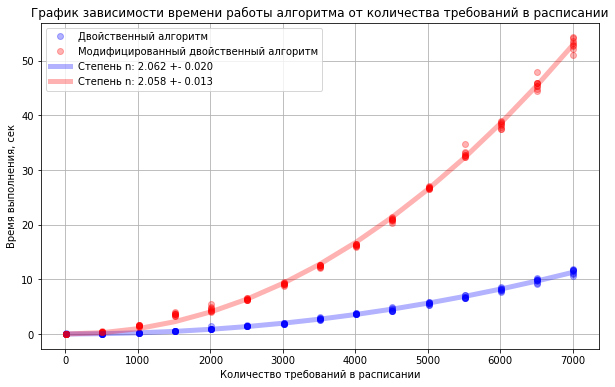

In [164]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(x, y, 'bo', alpha=0.3, label="Двойственный алгоритм")
ax.plot(xm, ym, 'ro', alpha=0.3, label="Модифицированный двойственный алгоритм")
ax.set_title("График зависимости времени работы алгоритма от количества требований в расписании")
ax.set_xlabel("Количество требований в расписании")
ax.set_ylabel("Время выполнения, сек")
ax.plot(x, poly(x, *popt), color='b', linewidth=5, alpha=0.3,
        label="Степень n: %.3f +- %.3f" % (popt[1], perr[1]))
ax.plot(xm, poly(xm, *poptm), color='r', linewidth=5, alpha=0.3,
        label="Степень n: %.3f +- %.3f" % (poptm[1], perrm[1]))
ax.legend()

In [95]:
results = {}

In [96]:
class Stat:
    
    def __init__(self):
        self.pi = 0
        self.k = 0
        self.phi = 0
        self.total = 0
        
    def add_data(self, pi, pi_m,
                k, k_m,
                phi, phi_m):
        if pi == pi_m:
            self.pi += 1
        if k == k_m:
            self.k += 1
        if phi == phi_m:
            self.phi += 1
        self.total += 1

def test(tasks):
    nTasks = len(tasks)
    if nTasks not in results.keys():
        results[nTasks] = Stat()
    pi, k, phi = dual_standard(tasks)
    pi_m, k_m, phi_m = dual_modified(tasks)
    results[nTasks].add_data(pi, pi_m,
                            k, k_m,
                            phi, phi_m)
    

In [97]:
def test_answers(minDim=10,
             maxDim=110,
             step=10,
             nExamples=100,
             **kwargs):
    results = {}
    taskList = [Task.generate_multiple(n)
                for n in range(minDim, maxDim, step)
                for i in range(nExamples)]

    for i, tasks in enumerate(taskList):
        print(i+1, "out of", len(taskList), "\r", end='')
        test(tasks)
    return results

In [ ]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.grid()
ax.plot(x, y, 'bo', alpha=0.3, label="Двойственный алгоритм")
ax.plot(xm, ym, 'ro', alpha=0.3, label="Модифицированный двойственный алгоритм")
ax.set_title("График зависимости времени работы алгоритма от количества требований в расписании")
ax.set_xlabel("Количество требований в расписании")
ax.set_ylabel("Время выполнения, сек")
ax.plot(x, poly(x, *popt), color='b', linewidth=5, alpha=0.3,
        label="Степень n: %.3f +- %.3f" % (popt[1], perr[1]))
ax.plot(xm, poly(xm, *poptm), color='r', linewidth=5, alpha=0.3,
        label="Степень n: %.3f +- %.3f" % (poptm[1], perrm[1]))
ax.legend()

## Итоги и выводы

- Случайным образом сгенерирован набор примеров размерностью от 10 до 7000 требований с шагом в 500 требований. Для каждой размерности из данного диапазона было сгенерировано по 8 примеров.
- Примеры сгенерированы в соответствии с требованием NNTS (non-negative time slack): $d_j - r_j - p_j \geq 0$ $\forall j \in N$.
- Экспериментально доказана сложность **обеих версий** "двойственного" алгоритма $O(n^2)$.
- Время проведения эксперимента уменьшено благодаря использованию многопоточных вычислений, которые дают выигрыш в производительности даже несмотря на [GIL](https://ru.wikipedia.org/wiki/Global_Interpreter_Lock).